# Import Libraries and Dataset

In [93]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go

import spacy
spacy = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from textblob import TextBlob

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import cross_val_score

import plotly.graph_objects as go
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import spacy
from collections import Counter

In [94]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# EDA

## Extracting the relevant columns

In [95]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [96]:
raw_df.isnull().sum()
raw_df.dropna(inplace=True)

In [97]:
# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

In [98]:
# sub reddit in sarcastic comments
sarcastic_comments['subreddit'].value_counts().head(10)

subreddit
AskReddit          26365
politics           23907
worldnews          16947
leagueoflegends    11407
pcmasterrace       10759
news               10193
funny               8099
pics                7823
todayilearned       7753
GlobalOffensive     7584
Name: count, dtype: int64

In [99]:
# sub reddit in non-sarcastic comments
n_sarcastic_comments['subreddit'].value_counts().head(10)

subreddit
AskReddit          39309
politics           15586
funny               9840
leagueoflegends     9627
worldnews           9428
pics                8329
pcmasterrace        8228
nfl                 6935
news                6698
nba                 6698
Name: count, dtype: int64

In [100]:
# percentage of sarcastic comments in each subreddit in descending order
percent = sarcastic_comments['subreddit'].value_counts() / raw_df['subreddit'].value_counts()
percent.sort_values(ascending=False, inplace=True)
percent.dropna(inplace=True)
percent

subreddit
0x10c               1.000000
helpmebuildapc      1.000000
LumiaLovers         1.000000
Luna_Lovewell       1.000000
M43                 1.000000
                      ...   
magicskyfairy       0.033333
pumparum            0.025641
ledootgeneration    0.022727
ACTrade             0.019608
friendsafari        0.014085
Name: count, Length: 8993, dtype: float64

In [101]:
# comments in each subreddit in descending order
comments_sub = raw_df['subreddit'].value_counts()
comments_sub.sort_values(ascending=False, inplace=True)

# filter out the subreddits with more than 8000 comments
comments_8000 = comments_sub[comments_sub > 8000]

# list of subreddits with more than 8000 comments
listcomments_8000 = comments_8000.index.tolist()


In [102]:
percent_8000 = percent[percent.index.isin(listcomments_8000)]
percent_8000 = percent_8000.reset_index()
percent_8000.columns = ['subreddit', 'percentage']
percent_8000


,subreddit,percentage
0,worldnews,0.642540
1,politics,0.605348
2,news,0.603457
3,pcmasterrace,0.566651
4,AdviceAnimals,0.560822
5,GlobalOffensive,0.552045
6,soccer,0.547658
7,todayilearned,0.547567
8,leagueoflegends,0.542312
9,hockey,0.528119


## Visualizing the data

In [103]:
# graph of the percentage of sarcastic comments in each subreddit with more than 8000 comments
fig = px.bar(percent_8000, x='subreddit', y='percentage', title='<b>Percentage of Sarcastic Comments in Each Subreddit')
# add labels above the bars
fig.update_traces(texttemplate='%{y:.2%}', textposition='outside')
fig.show()

In [104]:
# graph of the number of comments in each subreddit with more than 8000 comments
fig = px.bar(comments_8000, x=comments_8000.index, y=comments_8000.values, title='Number of Comments in Each Subreddit with More Than 8000 Comments')
# add x and y axis labels
fig.update_xaxes(title_text='Subreddit')
fig.update_yaxes(title_text='Number of Comments')
# add labels above the bars
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()

In [105]:
# compare the the number of comments in each subreddit with percentage of sarcastic comments in each subreddit 
fig = go.Figure()
fig.add_trace(go.Scatter(x=percent_8000['subreddit'], y=percent_8000['percentage'], 
                     mode='lines+markers+text', 
                     text=percent_8000['percentage'].round(2),
                     textposition='top center',
                     name='Percentage of Sarcastic Comments'))

fig.add_trace(go.Bar(x=comments_8000.index, y=comments_8000.values, 
                     texttemplate='%{y}', textposition='outside', 
                     textfont_color='black',
                     name='Number of Comments', yaxis='y2'))

fig.update_layout(
    title={
        'text': '<b>Percentage of Sarcastic Comments vs Number of Comments</b>',
        'font': {'size': 25, 'color': 'black'}
    },
    xaxis=dict(title='Subreddit'),
    yaxis=dict(title='Percentage of Sarcastic Comments'),
    yaxis2=dict(title='Number of Comments', overlaying='y', side='right'),
    legend=dict(x=0.8, y=1, xanchor='auto', yanchor='auto'),
    width=1000, height=600, plot_bgcolor='white'
)
fig.show()

In [106]:
# compare the the number of comments in each subreddit with percentage of sarcastic comments in each subreddit 
fig = go.Figure()
fig.add_trace(go.Bar(x=percent_8000['subreddit'], y=percent_8000['percentage'], 
                     texttemplate='%{y:.1%}', textposition='outside', 
                     name='Percentage of Sarcastic Comments'))

fig.add_trace(go.Bar(x=comments_8000.index, y=comments_8000.values, 
                     texttemplate='%{y}', textposition='outside', 
                     textfont_color='black',
                     name='Number of Comments', yaxis='y2'))
fig.update_layout(
    title={
        'text': '<b>Percentage of Sarcastic Comments vs Number of Comments</b>',
        'font': {'size': 25, 'color': 'black'}
    },
    xaxis=dict(title='Subreddit'),
    yaxis=dict(title='Percentage of Sarcastic Comments'),
    yaxis2=dict(title='Number of Comments', overlaying='y', side='right'),
    legend=dict(x=0.8, y=1, xanchor='auto', yanchor='auto'),
    width=1000, height=600, plot_bgcolor='white'
)
fig.show()


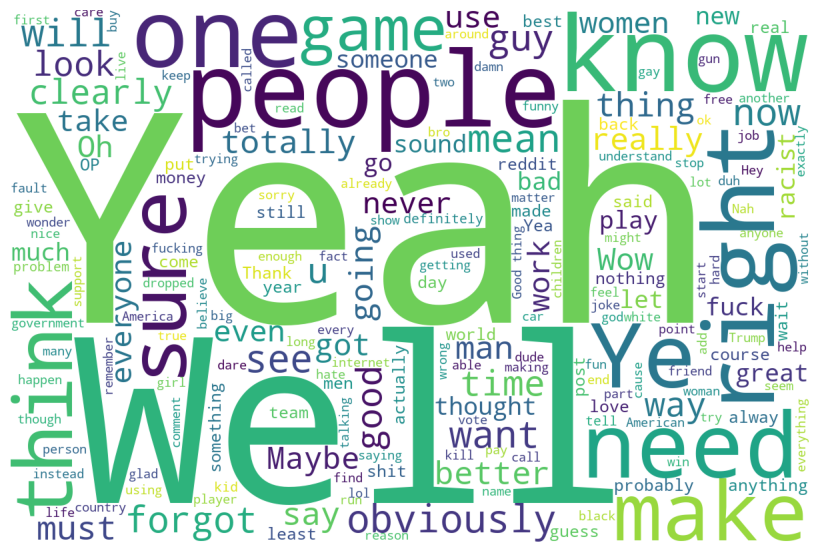

In [ ]:
# word cloud of the sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


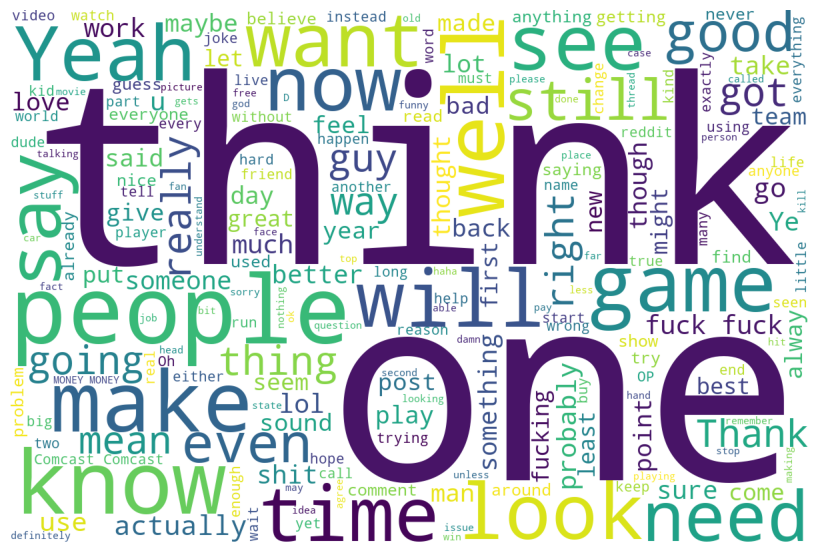

In [ ]:
# word cloud of the non-sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(n_sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
sub_df = raw_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

C:\Users\annab\AppData\Local\Temp\ipykernel_103220\794367598.py:1: FutureWarning:

The provided callable <function mean at 0x000002859D385F80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

C:\Users\annab\AppData\Local\Temp\ipykernel_103220\794367598.py:1: FutureWarning:

The provided callable <function sum at 0x000002859D384900> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [ ]:
# calculate the average score for sarcastic and non-sarcastic comments
sarcastic_comments['score'].mean().round(2), n_sarcastic_comments['score'].mean().round(2)

# plot the average score for sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Sarcastic', 'Non-Sarcastic'], y=[sarcastic_comments['score'].mean().round(2), n_sarcastic_comments['score'].mean().round(2)]))
fig.update_layout(
    title={
        'text': "<b>Average Score<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Type of Comment',
    yaxis_title='Average Score',
    autosize=False,
    width=400,
    plot_bgcolor='white'
    
)
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

In [ ]:
# plot the average score for sarcastic and non-sarcastic comments in each subreddit
df = sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(20).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()


In [ ]:
# plot the average score for non-sarcastic comments in each subreddit
df = n_sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(20).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Non-Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
# Set the width of the figure
fig.update_layout(autosize=False, width=800)
fig.show()

In [ ]:
# average up and down votes for sarcastic and non-sarcastic comments
sarcastic_comments['ups'].mean().round(2), n_sarcastic_comments['ups'].mean().round(2), sarcastic_comments['downs'].mean().round(2), n_sarcastic_comments['downs'].mean().round(2)

# plot the average up votes for sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Sarcastic', 'Non-Sarcastic'], y=[sarcastic_comments['ups'].mean().round(2), n_sarcastic_comments['ups'].mean().round(2)]))
fig.update_layout(
    title={
        'text': "<b>Average Up Votes<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Type of Comment',
    yaxis_title='Average Up Votes',
    autosize=False,
    width=400,
    plot_bgcolor='white' 
)
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

# plot the average down votes for sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Sarcastic', 'Non-Sarcastic'], y=[sarcastic_comments['downs'].mean().round(2), n_sarcastic_comments['downs'].mean().round(2)]))
fig.update_layout(
    title={
        'text': "<b>Average Down Votes<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Type of Comment',
    yaxis_title='Average Down Votes',
    autosize=False,
    width=400,
    plot_bgcolor='white'
)
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

In [ ]:
# plot the two lines: number of comments and number of sarcastic comments against time
df = raw_df.groupby('date')['label'].agg([np.size, np.sum])
df = df.reset_index()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['size'], mode='lines', 
                         line=dict(color='blue'), name='Number of Comments'))
fig.add_trace(go.Scatter(x=df['date'], y=df['sum'], mode='lines', 
                         line=dict(color='red'), name='Number of Sarcastic Comments'))
fig.update_layout(title='Number of Comments and Sarcastic Comments Against Time')
fig.show()

C:\Users\annab\AppData\Local\Temp\ipykernel_103220\2617056600.py:2: FutureWarning:

The provided callable <function sum at 0x000002859D384900> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



## Exploratory Using spaCY

In [ ]:
spacy.max_length = 3000000  # Override the default allowed max length for a doc object

def process_comments_spacy(df, sample_size, random_state):
    df_sample = df.sample(sample_size, replace=False, random_state=random_state)
    df_sample['comment'] = df_sample['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_en)]))
    text_list = df_sample['comment'].tolist()
    text = " ".join(text_list)
    doc = spacy(text)
    return doc

sarcasm_doc = process_comments_spacy(sarcastic_comments, 50000, 42)
non_sarcasm_doc = process_comments_spacy(n_sarcastic_comments, 50000, 42)

### Exclemation Mark and Question Mark Analysis

In [ ]:
def count_character_type(str):
    excla = 0
    quest = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            excla+=1
        elif ch == "?":
            quest+=1
        
    return excla, quest

excl_sarcasm, quest_sarcasm = count_character_type(str(sarcasm_doc))
excl_non, quest_non = count_character_type(str(non_sarcasm_doc))

# plot the number of exclamation and question marks in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_sarcasm, quest_sarcasm],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_non, quest_non],
                        name='Non-Sarcastic Comments'))
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.update_layout(
    title={
        'text': "<b>Number of Exclamation and Question Marks<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    width=700, 
    legend=dict(x=0.5, y=1, xanchor='auto', yanchor='auto'),
    plot_bgcolor='white', 
    paper_bgcolor='white'
)
fig.show()

However, we already know that AskReddit is mostly about questions, so we eliminate this subreddit from the dataset and search again.

In [ ]:
# eliminate AskReddit
sarcastic_nAR = sarcastic_comments[sarcastic_comments['subreddit'] != 'AskReddit']
n_sarcastic_nAR = n_sarcastic_comments[n_sarcastic_comments['subreddit'] != 'AskReddit']

sarcasm_nAR = process_comments_spacy(sarcastic_nAR, 50000, 42)
non_sarcasm_nAR = process_comments_spacy(n_sarcastic_nAR, 50000, 42)

In [ ]:
excl_sarcasm, quest_sarcasm = count_character_type(str(sarcasm_nAR))
excl_non, quest_non = count_character_type(str(non_sarcasm_nAR))

# plot the number of exclamation and question marks in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_sarcasm, quest_sarcasm],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_non, quest_non],
                        name='Non-Sarcastic Comments'))
fig.update_layout(title='Number of Exclamation and Question Marks in Sarcastic and Non-Sarcastic Comments')
fig.show()

It makes no difference, so we will continue with the analysis.

## Capitalization Analysis

In [ ]:
# plot the number of capital letters in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Sarcastic Comments'], y=[len([word for word in str(sarcasm_doc) if word.isupper()])],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Non-Sarcastic Comments'], y=[len([word for word in str(non_sarcasm_doc) if word.isupper()])],
                        name='Non-Sarcastic Comments'))
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.update_layout(
    title={
        'text': "<b>Number of Capital Letters<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Type of Comment',
    yaxis_title='Number of Capital Letters',
    autosize=False,
    width=500,
    plot_bgcolor='white', 
    paper_bgcolor='white',
    showlegend=False
)
fig.show()

People tend to use capital letters when they being sarcastic, but not much.

## Dependency Parsing

In [ ]:
# dependency parsing
def dependency_parsing(doc):
    dep = defaultdict(int)
    for token in doc:
        dep[token.dep_] += 1
    return dep

sarcasm_dep = dependency_parsing(sarcasm_doc)
non_sarcasm_dep = dependency_parsing(non_sarcasm_doc)

# plot the dependency parsing in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=list(sarcasm_dep.keys()), y=list(sarcasm_dep.values()), name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=list(non_sarcasm_dep.keys()), y=list(non_sarcasm_dep.values()), name='Non-Sarcastic Comments'))
fig.update_layout(title='Dependency Parsing in Sarcastic and Non-Sarcastic Comments')
fig.show()

# Benchmark

In [ ]:
# Split the data first
X_train, X_test, Y_train, Y_test = train_test_split(raw_df, raw_df['label'], random_state=0)

In [ ]:
def create_dummy_columns(data, column_name):
    dummy_columns = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    data = pd.concat([data, dummy_columns], axis=1)
    data = data.drop(columns=[column_name])
    return data

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store accuracies
accuracies_random = []
accuracies_word = []
accuracies_upvotes_downvotes_score = []

def count_words(comment):
    if isinstance(comment, str):
        return len(comment.split())
    else:
        return 0

# Loop over each fold
for train_index, test_index in kf.split(raw_df):
    X_train, X_test = raw_df.iloc[train_index], raw_df.iloc[test_index]
    Y_train, Y_test = raw_df['label'].iloc[train_index], raw_df['label'].iloc[test_index]

    # Random classifier
    random_clf = DummyClassifier(strategy='uniform', random_state=0)
    random_clf.fit(X_train, Y_train)
    Y_pred_random = random_clf.predict(X_test)
    accuracies_random.append(accuracy_score(Y_test, Y_pred_random))

    # Benchmark using word count
    X_train_word_count = X_train['comment'].apply(count_words)
    X_test_word_count = X_test['comment'].apply(count_words)
    word_clf = DummyClassifier(strategy='most_frequent')
    word_clf.fit(X_train_word_count.to_frame(), Y_train)
    Y_pred_word = word_clf.predict(X_test_word_count.to_frame())
    accuracies_word.append(accuracy_score(Y_test, Y_pred_word))

    # Benchmark using upvotes/downvotes and score
    X_train, X_test, Y_train, Y_test = train_test_split(raw_df, raw_df['label'], random_state=0)

    X_train = X_train.drop(columns=['label', 'comment', 'parent_comment', 'author', 'subreddit', 'date', 'created_utc'])
    X_test = X_test.drop(columns=['label', 'comment', 'parent_comment', 'author', 'subreddit', 'date', 'created_utc'])

    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accuracies_upvotes_downvotes_score.append(accuracy_score(Y_test, Y_pred))


# Data Preprocessing

In [ ]:
# type of each column
raw_df.dtypes

label              int64
comment           object
author            object
subreddit         object
score              int64
ups                int64
downs              int64
date              object
created_utc       object
parent_comment    object
dtype: object

In [ ]:
# normalize the date column
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['date'] = raw_df['date'].dt.normalize()
raw_df['created_utc'] = pd.to_datetime(raw_df['created_utc'])
raw_df['created_utc'] = raw_df['created_utc'].dt.normalize()
raw_df.dtypes

label                      int64
comment                   object
author                    object
subreddit                 object
score                      int64
ups                        int64
downs                      int64
date              datetime64[ns]
created_utc       datetime64[ns]
parent_comment            object
dtype: object

In [ ]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def process_comment(comment):
    # we still need the capital letters, so we don't convert the comment to lowercase
    tokens = word_tokenize(comment)
    tokens = [word for word in tokens if word not in string.punctuation or word in ['!', '?']]
    # remove stop words has been proved to decrease the accuracy
    # tokens = [word for word in tokens if word not in stop_words]
    # lemmatize the words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the words back together
    return ' '.join(tokens)

## Comments


In [ ]:
raw_df['processed_comment'] = raw_df['comment'].astype(str).apply(process_comment)

In [ ]:
def print_results(number):
    print(f"Original Comment: {raw_df['comment'][number]}")
    print(f"Processed Comment: {raw_df['processed_comment'][number]}")

print_results(10)

Original Comment: I think a significant amount would be against spending their tax dollars on other people.
Processed Comment: I think a significant amount would be against spending their tax dollar on other people


# Add Features Modelling

Based on above analysis, we will add the following features to the dataset: score, upvote, downvote and subreddit. Because all other features besides the subreddit are numbers, we will use **one-hot encoding** and **target encoding** for the subreddit feature.

### One-Hot Encoding - Subreddit

In [ ]:
def create_dummy_columns(data, column_name):
    dummy_columns = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    data = pd.concat([data, dummy_columns], axis=1)
    data = data.drop(columns=[column_name])
    return data

In [ ]:
# filter out the subreddits with more than 2000 comments, and create a new dataframe with those comments
comments_sub = raw_df['subreddit'].value_counts()
comments_2000 = comments_sub[comments_sub > 2000]
listcomments_2000 = comments_2000.index.tolist()
df_2000 = raw_df[raw_df['subreddit'].isin(listcomments_2000)]

In [ ]:
# use a fraction of the data, cause the data is too large, and our computer can't handle it
raw_df1 = df_2000.sample(frac=0.009, random_state=0)

In [ ]:
raw_df1['comment'] = raw_df1['comment'].astype(str).apply(process_comment)

In [ ]:
# create dummy columns for the subreddit column
raw_df1 = create_dummy_columns(raw_df1, 'subreddit')

# drop the nan values
raw_df1.dropna(inplace=True)

In [ ]:
# vectorize the parent_comment and comment columns
vectorizer = TfidfVectorizer(ngram_range=(1,2))
# X_parent = vectorizer.fit_transform(raw_df['parent_comment'])
X_comment = vectorizer.fit_transform(raw_df1['comment'])

In [ ]:
# drop the columns that are not needed
raw_df1.drop(columns=['parent_comment', 'comment', 'author', 'date', "created_utc"], inplace=True)

# if process_comment is in raw_df1, drop it
if 'processed_comment' in raw_df1.columns:
    raw_df1.drop(columns=['processed_comment'], inplace=True)

In [ ]:
# convert sparse matrix to dataframe
X_comment_df = pd.DataFrame(X_comment.toarray(), index=raw_df1.index, columns=vectorizer.get_feature_names_out())

# concatenate the dataframes
X = pd.concat([raw_df1, X_comment_df], axis=1)

# drop the label column
X.drop(columns=['label'], inplace=True)

In [ ]:
# make sure the lenths of the two dataframes are the same
len(X_comment.toarray()), len(raw_df1)
print(len(X))
print(len(raw_df1['label']))

4896
4896


In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(X,raw_df1['label'],random_state=0)

# Create a new pipeline
lr_pipe = Pipeline([('clf',  LogisticRegression(random_state = 0, solver='liblinear', C=0.1 ))])

# Fit the model
lr_pipe.fit(X_train, Y_train)

# Make predictions
Y_pred = lr_pipe.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# print test and train accuracy
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Train Accuracy: {lr_pipe.score(X_train, Y_train):.2f}")

Test Accuracy: 0.56
Train Accuracy: 0.67


In [ ]:
one_hot_scores = cross_val_score(lr_pipe, X_train, Y_train, cv=5)

# Convert the scores to a list
one_hot_scores = list(one_hot_scores)

# Now one_hot_scores is a list, similar to your previous format
one_hot_scores

[0.564625850340136,
 0.5619047619047619,
 0.5940054495912807,
 0.5572207084468664,
 0.5803814713896458]

In [ ]:
# show n-granms coefficients
ngrams = X.columns
coef = lr_pipe.named_steps['clf'].coef_[0]

ngram_coef = pd.DataFrame({'ngram': ngrams, 'coef': coef})
ngram_coef = ngram_coef.sort_values(by='coef', ascending=False)
ngram_coef.head(10)

,ngram,coef
72,subreddit_worldnews,0.593928
34,subreddit_creepyPMs,0.529039
3965,because,0.506141
11492,forgot,0.500975
5335,but,0.475288
38110,yeah,0.460437
27,subreddit_atheism,0.458566
54,subreddit_nba,0.355652
12,subreddit_KotakuInAction,0.326501
62,subreddit_politics,0.315172


### Target Encoding - Subreddit

In [ ]:
# use a fraction of the data
raw_df2 = raw_df.sample(frac=1, random_state=0)

In [ ]:
# raw_df2['comment'] = raw_df2['comment'].astype(str).apply(process_comment)

In [ ]:
# target encoding
subreddit_mean = raw_df2.groupby('subreddit')['label'].mean()
raw_df2['subreddit'] = raw_df2['subreddit'].map(subreddit_mean)

# drop the nan values
raw_df2.dropna(inplace=True)

In [ ]:
# vectorize the parent_comment and comment columns
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.01)
# X_parent = vectorizer.fit_transform(raw_df['parent_comment'])
X_comment = vectorizer.fit_transform(raw_df2['processed_comment'])

In [ ]:
# drop the columns that are not needed
raw_df2.drop(columns=['parent_comment', 'comment', 'author', 'date', "created_utc"], inplace=True)

# if process_comment is in raw_df2, drop it
if 'processed_comment' in raw_df2.columns:
    raw_df2.drop(columns=['processed_comment'], inplace=True)

In [ ]:
# convert sparse matrix to dataframe
X_comment_df = pd.DataFrame(X_comment.toarray(), index=raw_df2.index, columns=vectorizer.get_feature_names_out())

# concatenate the dataframes
X = pd.concat([raw_df2, X_comment_df], axis=1)

# drop the label column
X.drop(columns=['label'], inplace=True)

In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(X,raw_df2['label'],random_state=0)

# Create a new pipeline
lr_pipe = Pipeline([('clf',  LogisticRegression(random_state = 0, solver='liblinear', C=0.1))])

# Fit the model
lr_pipe.fit(X_train, Y_train)

# Make predictions
Y_pred = lr_pipe.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# print test and train accuracy
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Train Accuracy: {lr_pipe.score(X_train, Y_train):.2f}")

Test Accuracy: 0.63
Train Accuracy: 0.63


In [ ]:
target_scores = cross_val_score(lr_pipe, X_train, Y_train, cv=5)

# Convert the scores to a list
target_scores = list(target_scores)

# Now one_hot_scores is a list, similar to your previous format
target_scores

[0.6342206627268889,
 0.6340557724778387,
 0.6323936787674124,
 0.6331695412723015,
 0.6360650331431587]

In [ ]:
# show n-granms coefficients
ngrams = X.columns
coef = lr_pipe.named_steps['clf'].coef_[0]

ngram_coef = pd.DataFrame({'ngram': ngrams, 'coef': coef})
ngram_coef = ngram_coef.sort_values(by='coef', ascending=False)
ngram_coef.head(10)

,ngram,coef
0,subreddit,4.259196
74,obviously,3.604732
138,yeah,2.700976
14,because,2.507163
6,all,1.226495
95,should,1.217850
101,sure,1.216948
18,but,1.129716
89,right,1.094494
77,oh,1.033551


## Results summary

In [ ]:
# Create a box plot
fig = go.Figure()

# Add box plots
fig.add_trace(go.Box(y=accuracies_random, name='Random'))
fig.add_trace(go.Box(y=accuracies_word, name='Word Count'))
fig.add_trace(go.Box(y=accuracies_upvotes_downvotes_score, name='Upvotes/Downvotes/Score'))

# Calculate mean accuracies
mean_accuracies = [np.mean(accuracies_random), np.mean(accuracies_word), np.mean(accuracies_upvotes_downvotes_score)]

# Add mean accuracy scores as text annotations
for i, mean_accuracy in enumerate(mean_accuracies):
    fig.add_annotation(
        x=i+1,
        y=mean_accuracy,
        text=str(round(mean_accuracy, 4)),
        showarrow=False,
        font=dict(
            size=12
        ),
        yshift=25,
        xshift=-290
    )

fig.update_layout(title='<b>Benchmark Accuracy', showlegend=False)

fig.show()

In [ ]:
# Create a box plot
fig = go.Figure()

# Add box plots
fig.add_trace(go.Box(y=accuracies_random, name='Random'))
fig.add_trace(go.Box(y=accuracies_word, name='Word Count'))
fig.add_trace(go.Box(y=accuracies_upvotes_downvotes_score, name='Upvotes/Downvotes/Score'))
fig.add_trace(go.Box(y=one_hot_scores, name='One Hot Encoding'))
fig.add_trace(go.Box(y=target_scores, name='Target Encoding'))

# Calculate mean accuracies
mean_accuracies = [np.mean(accuracies_random), np.mean(accuracies_word), np.mean(accuracies_upvotes_downvotes_score), np.mean(one_hot_scores), np.mean(target_scores)]

# Add mean accuracy scores as text annotations
for i, mean_accuracy in enumerate(mean_accuracies):
    fig.add_annotation(
        x=i+1,
        y=mean_accuracy,
        text=str(round(mean_accuracy, 4)),
        showarrow=False,
        font=dict(
            size=12
        ),
        yshift=20,
        xshift=-153
    )

fig.update_layout(title='<b>Benchmark Accuracy<b> VS<b> Meta-Features', showlegend=False, width=1000, height=600)

fig.show()

# Train the model

In [ ]:
raw_df1 = raw_df.sample(frac=1, random_state=42)

In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(raw_df1['processed_comment'].astype(str),raw_df1['label'], test_size=0.2,random_state=0)

## SpaCY

In [ ]:
def process_text_spacy(text):

    nlp = spacy.load('en_core_web_sm')
    # Process text
    doc = nlp(text)
    # POS tagging
    pos_tags = [(token.text, token.pos_) for token in doc]
    # NER
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]
    # Dependency Parsing
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]
    # Word Vectors (we use the has_vector attribute to check if a word has a vector)
    word_vectors = [(token.text, token.vector) for token in doc if token.has_vector]
    # Sentence Boundary Detection
    sentences = [sent.text for sent in doc.sents]
    # Lemmatization
    lemmas = [(token.text, token.lemma_) for token in doc]
    # High frequency / Low frequency words
    word_freq = Counter(token.text for token in doc)
    high_freq = [word for word, freq in word_freq.items() if freq > 5]
    low_freq = [word for word, freq in word_freq.items() if freq == 1]

    return {
        'pos_tags': pos_tags,
        'named_entities': named_entities,
        'dependencies': dependencies,
        'word_vectors': word_vectors,
        'sentences': sentences,
        'lemmas': lemmas,
        'high_freq_words': high_freq,
        'low_freq_words': low_freq
    }

In [ ]:
# sample the raw_df
raw_df_sample = raw_df.sample(frac=0.0001, random_state=0)

len(raw_df_sample)

101

In [ ]:
# Create a function to extract features
def extract_features(doc):
    return {
        'num_pos': len(doc['pos_tags']),
        'num_entities': len(doc['named_entities']),
        'num_dependencies': len(doc['dependencies']),
        'num_sentences': len(doc['sentences']),
        'num_lemmas': len(doc['lemmas']),
        'num_high_freq': len(doc['high_freq_words']),
        'num_low_freq': len(doc['low_freq_words']),
    }

# Extract features for each document
features = [extract_features(process_text_spacy(comment)) for comment in raw_df_sample['processed_comment']]

# Convert features to a DataFrame
features_df = pd.DataFrame(features)

,num_pos,num_entities,num_dependencies,num_sentences,num_lemmas,num_high_freq,num_low_freq
0,2,1,2,1,2,0,2
1,9,1,9,1,9,0,9
2,29,1,29,1,29,0,23
3,26,0,26,2,26,0,13
4,19,0,19,1,19,0,15
...,...,...,...,...,...,...,...
96,12,1,12,1,12,0,12
97,16,0,16,1,16,0,14
98,6,0,6,1,6,0,6
99,4,0,4,1,4,0,4


In [ ]:
labels = raw_df_sample['label'].tolist()

# Create a DictVectorizer
vectorizer = DictVectorizer()

# Create a pipeline
pipe = make_pipeline(vectorizer, LogisticRegression())

# Train the model
pipe.fit(features, labels)

# Make predictions
Y_pred = pipe.predict(features)

# Calculate the accuracy
accuracy = accuracy_score(labels, Y_pred)

# print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


## Logistic Regression

### N-gram Range Selection

In [ ]:
# different range of n-grams
ngram_ranges = [(1,1), (1,2), (1,3), (1,4), (1,5)]

# Create a list to store the accuracies
accuracies_test = []

# Loop over each n-gram range
for ngram_range in ngram_ranges:
    # Create a pipeline
    pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=ngram_range)),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])

    # Train the model
    pipe.fit(X_train, Y_train)

    # Make predictions
    Y_pred = pipe.predict(X_test)

    # Calculate the accuracy of the test data
    accuracy_test = accuracy_score(Y_test, Y_pred)

    # Append the accuracy to the list
    accuracies_test.append(accuracy_test)

In [ ]:
accuracies_train = []

# Loop over each n-gram range
for ngram_range in ngram_ranges:
    # Create a pipeline
    pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=ngram_range)),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])

    # Train the model
    pipe.fit(X_train, Y_train)

    # Make predictions
    Y_pred = pipe.predict(X_test)

    # Calculate the accuracy of the test data
    accuracy_train = pipe.score(X_train, Y_train)

    # Append the accuracy to the list
    accuracies_train.append(accuracy_train)

In [ ]:
# Create a line plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'{ngram_range[0]}-{ngram_range[1]}' for ngram_range in ngram_ranges], y=accuracies_test, mode='lines+markers', name='Out-of-Sample'))
fig.add_trace(go.Scatter(x=[f'{ngram_range[0]}-{ngram_range[1]}' for ngram_range in ngram_ranges], y=accuracies_train, mode='lines+markers', name='In-Sample'))
fig.update_layout(title='<b>Accuracy for Different N-Gram Ranges</b>')
fig.show()

### Without Stop Words

In [ ]:
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [ ]:
lr_score_ns = cross_val_score(lr_clf, X_train, Y_train, cv=5)

# Convert the scores to a list
lr_score_ns = list(lr_score_ns)

# Now one_hot_scores is a list, similar to your previous format
lr_score_ns

[0.7193675644925923,
 0.7194833140616981,
 0.7215794908578248,
 0.7212579534141711,
 0.7205592278154622]

In [ ]:
print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8143259594170781
The accuracy on the test set is:  0.7239791249288912


In [ ]:
# print n-grams coefficients
ngram = lr_clf.named_steps['tfidf']
feature_names = np.array(ngram.get_feature_names_out())
coefficients = lr_clf.named_steps['clf'].coef_[0]
coefficients_df = pd.DataFrame({'ngram': feature_names, 'coefficient': coefficients})
coefficients_df = coefficients_df.sort_values('coefficient', ascending=False)
coefficients_df.head(10)

,ngram,coefficient
1951176,yes because,10.882223
1174695,obviously,10.754011
355779,clearly,10.053116
1760577,totally,9.354867
210011,because,9.348097
1945413,yeah because,8.697399
700514,good thing,6.829244
508396,duh,6.820205
557649,everyone know,6.695469
802365,how dare,6.440604


In [ ]:
# Get top 20 and bottom 20 coefficients
top_df = coefficients_df.head(30)
bottom_df = coefficients_df.tail(30)

# Concatenate the dataframes
combined_df = pd.concat([top_df, bottom_df])

# Create scatter plot
fig = go.Figure(data=go.Scatter(
    x=combined_df['coefficient'],
    y=combined_df.index,
    mode='markers+text',
    text=combined_df['ngram'],
    textposition='top center'
))

fig.update_layout(
    title='Top and Bottom N-Gram Coefficients',
    xaxis_title='Coefficient',
    yaxis_title='N-gram'
)

fig.show()

In [ ]:
# Get top 20 and bottom 20 coefficients
top_df = coefficients_df.head(10)
bottom_df = coefficients_df.tail(10)

# Concatenate the dataframes
combined_df = pd.concat([top_df, bottom_df])

# Plot n gram coefficients
fig = px.bar(combined_df, x='ngram', y='coefficient', title='Top and Bottom N-Gram Coefficients')
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig.show()

### With Stop Words

In [ ]:
# remove the stop words
stop_words = list(set(stopwords.words('english')))
lr_clf_s = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf_s.fit(X_train,Y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['her', 'hers', 'i', 'below', 'not',
                                             'if', 'yours', 'all', 'be',
                                             'between', 'y', "aren't",
                                             "mustn't", 'most', "won't",
                                             'should', 'd', 'doesn', 'they',
                                             'very', 'ourselves', "hadn't",
                                             'in', 'shan', 'have', 'll', 'me',
                                             've', 'were', 'theirs', ...])),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [ ]:
print(f"The accuracy on the training set is: {lr_clf_s.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf_s.score(X_test,Y_test)}")

In [ ]:
lr_score_s = cross_val_score(lr_clf_s, X_train, Y_train, cv=5)

# Convert the scores to a list
lr_score_s = list(lr_score_s)

# Now one_hot_scores is a list, similar to your previous format
lr_score_s

[0.6916380184502757,
 0.6895357752331017,
 0.6898016471693913,
 0.6895976059159598,
 0.6899995053545371]

### Combining the Parent Comment and the Comment

In [ ]:
pc_df = raw_df

In [ ]:
# combine the parent_comment and comment columns
pc_df['combined_comment'] = pc_df['parent_comment'] + ' ' + pc_df['comment'] 

# create a new column 'is_parent_comment', where if the comment is the same as the parent_comment, then it is 1, otherwise 0
pc_df['is_parent_comment'] = np.where(pc_df['combined_comment'] == pc_df['parent_comment'], 1, 0)

In [ ]:
# in 'label' column, if the comment is the same as the parent_comment, then it is 0, otherwise do nothing
pc_df['label'] = np.where(pc_df['combined_comment'] == pc_df['parent_comment'], 0, pc_df['label'])

In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(pc_df['combined_comment'].astype(str),pc_df['label'], test_size=0.2,random_state=0)

lr_clf_p = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf_p.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [ ]:
print(f"The accuracy on the training set is: {lr_clf_p.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf_p.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8146847871787896
The accuracy on the test set is:  0.6868909707863835


In [ ]:
lr_score_p = cross_val_score(lr_clf_s, X_train, Y_train, cv=5)

# Convert the scores to a list
lr_score_p = list(lr_score_p)

# Now one_hot_scores is a list, similar to your previous format
lr_score_p

[0.6619531076101205,
 0.6603269606509534,
 0.6612606039621102,
 0.6615326589666857,
 0.6621138673855514]

### Results summary

In [67]:
# Create a box plot
fig = go.Figure()

# Add box plots
fig.add_trace(go.Box(y=accuracies_random, name='Random'))
fig.add_trace(go.Box(y=accuracies_word, name='Word Count'))
fig.add_trace(go.Box(y=accuracies_upvotes_downvotes_score, name='Upvotes/Downvotes/Score'))
fig.add_trace(go.Box(y=lr_score_ns, name='Without Stop Words'))
fig.add_trace(go.Box(y=lr_score_s, name='With Stop Words'))
fig.add_trace(go.Box(y=lr_score_p, name='With Parent Comment'))

# Calculate mean accuracies
mean_accuracies = [np.mean(accuracies_random), np.mean(accuracies_word), np.mean(accuracies_upvotes_downvotes_score), np.mean(lr_score_ns), np.mean(lr_score_s), np.mean(lr_score_p)]

# Add mean accuracy scores as text annotations
for i, mean_accuracy in enumerate(mean_accuracies):
    fig.add_annotation(
        x=i+1,
        y=mean_accuracy,
        text=str(round(mean_accuracy, 4)),
        showarrow=False,
        font=dict(
            size=12
        ),
        yshift=20,
        xshift=-130
    )

fig.update_layout(title='<b>Benchmark Accuracy<b> VS<b> Logistic Regression with N-Grams', showlegend=False, width=1000, height=700)

fig.show()

### Predict Parent Comment

In [ ]:
raw_df['processed_p_comment'] = raw_df['parent_comment'].astype(str).apply(process_comment)

In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(raw_df['processed_p_comment'].astype(str),raw_df['label'], test_size=0.2,random_state=0)

# Create a new pipeline
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state = 0, solver='liblinear', c= 0.1))])
lr_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.7971038508149284
The accuracy on the test set is:  0.588180010486432


In [14]:
# print n-grams coefficients
ngram = lr_clf.named_steps['tfidf']
feature_names = np.array(ngram.get_feature_names_out())
coefficients = lr_clf.named_steps['clf'].coef_[0]
coefficients_df = pd.DataFrame({'ngram': feature_names, 'coefficient': coefficients})
coefficients_df = coefficients_df.sort_values('coefficient', ascending=False)
coefficients_df.head(10)

,ngram,coefficient
2915971,sarcasm,5.979618
2916240,sarcastic,3.911285
3817050,woman,3.240352
2746135,raped,3.186837
1208199,fault,2.980768
57962,30fps,2.819323
2731086,racist,2.727789
83263,60fps,2.722954
723547,clearly,2.694897
2730724,racism,2.542434


In [15]:
# with removing stop words
stop_words = list(set(stopwords.words('english')))
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8342814038038237
The accuracy on the test set is:  0.5829714195265278


In [21]:
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)),
                   ('clf',  LogisticRegression(random_state = 0, solver='liblinear', C=0.2))])  # Increase the C parameter
lr_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.6848428264041748
The accuracy on the test set is:  0.5853259202833315


## XGBoost

In [39]:
# xgboost

xgb_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  XGBClassifier())])
xgb_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {xgb_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {xgb_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.6961739465360274
The accuracy on the test set is:  0.6796856450923595


In [24]:
# with stop words
stop_words = list(set(stopwords.words('english')))
xgb_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)),('clf',  XGBClassifier())])
xgb_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {xgb_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {xgb_clf.score(X_test,Y_test)}") 

The accuracy on the training set is: 0.6611406524373655
The accuracy on the test set is:  0.6497234945539804
